## Amazon Product Sentiment Analysis

In [60]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandhya.mukkamala\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sandhya.mukkamala\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sandhya.mukkamala\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [3]:
# Covert json file into csv
df = pd.read_json('Clothing_Shoes_and_Jewelry_5.json', lines=True)
df.to_csv('reviews.csv', sep=',', index=False)

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [6]:
# adding new columns to perform the efficiency of helpfulness metrics
df[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,HelpfulnessNumerator,HelpfulnessDenominator
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",0,0
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",0,0
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",0,0
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014",0,0
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",0,0


### Data preprocessing

Remove the duplicates if any, based on the reviewerID, productID (asin) and unix timestamp. Adding the upvote metrics to analyze the dataset

In [9]:
#Cleaning the data by eliminating duplicates
df.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
df['% Upvote'] = pd.cut(df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df['Id'] = df.index;
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",0,0,-1.0,Empty,0
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",0,0,-1.0,Empty,1
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",0,0,-1.0,Empty,2
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014",0,0,-1.0,Empty,3
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",0,0,-1.0,Empty,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014",0,1,0.0,Empty,278672
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014",0,0,-1.0,Empty,278673
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014",1,1,1.0,80-100%,278674
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014",2,2,1.0,80-100%,278675


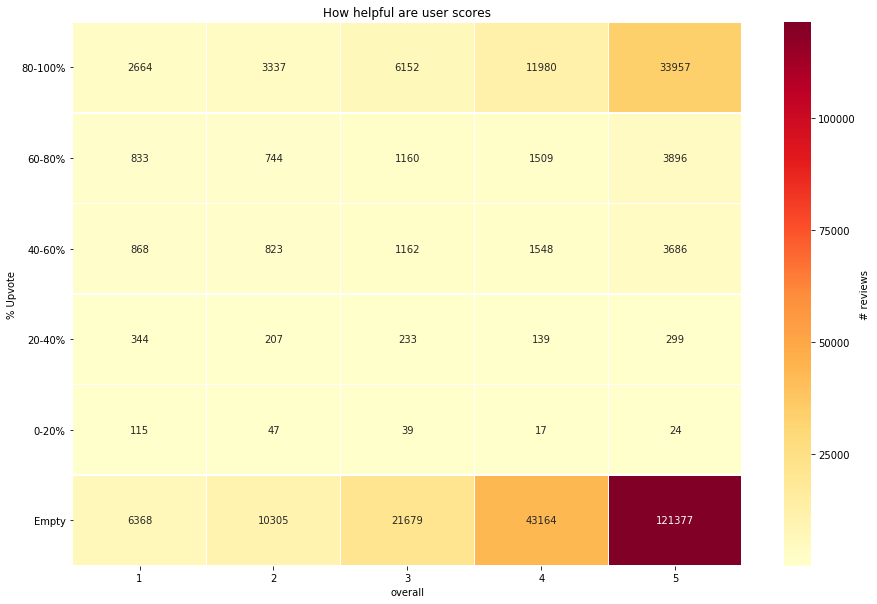

In [11]:
# find how useful are the user reviews
df1 = df.groupby(['overall', '% Upvote']).agg({'Id': 'count'})
df1 = df1.unstack()
df1.columns = df1.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df1[df1.columns[::-1]].T, cmap = 'YlOrRd', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful are user scores')
plt.show()

We can remove the rating of 3 and convert the reviews into binary, 1 - positive, 0 - negative for better analysis as rating 3 is neither good not bad and we dont get much out of it

In [15]:
reviews =  df[df['overall'] != 3]
X = reviews['reviewText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = reviews['overall'].map(y_dict)

In [19]:
# Performing logistic regression on word count
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 20 positive')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 20 negative')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 73968
# train records: 186189
# test records: 62063


C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9370639511464157

Top 20 positive
        Word  Coefficient
  pleasantly     3.226059
      hiding     2.356712
 compliments     2.260568
     alittle     2.044379
       loves     2.034339
        gore     2.033173
    precious     2.002526
    softened     1.992407
       comet     1.989498
 appreciated     1.962651
        beat     1.890330
      highly     1.880804
   complaint     1.836577
     quicker     1.834540
     worried     1.806284
        glad     1.804042
   organized     1.798408
      chubby     1.794730
        hugs     1.785729
     pleased     1.760432

Top 20 negative
           Word  Coefficient
        ugliest    -1.990887
       returned    -1.995907
          awful    -2.010392
        presses    -2.016764
     unwearable    -2.033194
           tore    -2.105088
           skip    -2.129849
   unacceptable    -2.133191
      worthless    -2.155625
        donated    -2.220157
 disappointment    -2.274072
         poorly    -2.287932
       g

It can observed that the few words with highest positive and negative coeffcient doesn't make sense such as (complaint - 1.836577, worried - 1.806284, goodwill - -2.294153). Baseline accuracy of the model is as follows:

In [20]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 73968
# train records: 186189
# test records: 62063
Model Accuracy: 0.8101445305576591


TF-IDF vectorizer is added to logistic regression to improve the model accuracy

In [22]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 73968
# train records: 186189
# test records: 62063


C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9383046259446047

Top 20 positive
        Word  Coefficient
        love    11.159220
       great    11.010378
     perfect    10.111874
 comfortable     8.772221
       loves     7.438456
   perfectly     7.058265
 compliments     6.901423
        nice     6.743366
      highly     6.451530
     pleased     6.313346
      little     6.214533
        glad     5.872873
   excellent     5.831445
        easy     5.531104
     exactly     5.435831
         bit     5.040384
       happy     5.025105
      nicely     4.924161
        best     4.900944
        fits     4.848919

Top 20 negative
           Word  Coefficient
           junk    -4.524156
          worst    -4.859971
          awful    -5.032494
         return    -5.185458
        cheaply    -5.220782
          cheap    -5.255922
       horrible    -5.356994
 disappointment    -5.432903
          shame    -5.504756
       terrible    -5.519242
        useless    -5.545926
         poorly    -5.683921
        

Accuracy with tfidf has increased from 81% to 93.8%. It can also be observed that words that don't indicate polarity of the sentiment are removed.

### Upvote prediction

Analysing the pattern of downvotes by users to predict upvotes of the products

In [25]:
reviews = df[df['overall'] == 5]
reviews = reviews[reviews['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = reviews['reviewText']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = reviews['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    37853
0.0      323
Name: % Upvote, dtype: int64


It can be observed that the upvotes are skewed towards positive side. To avoid it, resampling the data has to be performed.

In [26]:
df2 = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df2[df2['% Upvote'] == 0])
Downvote_indices = np.array(df2[df2['% Upvote'] == 0].index)

Upvote_indices = df2[df2['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df2.loc[under_sample_indices, :]
X_u = under_sample_data['reviewText']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  646


Now, the similar operations as above are performed on the resampled data to measure accuracy of the model

In [27]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 5155
# train records: 484
# test records: 162
Model Accuracy: 0.5370370370370371

Top 20 positive
     Word  Coefficient
     cool     0.921828
  pleased     0.755763
     warm     0.751756
   highly     0.748763
  picture     0.723473
   purple     0.689130
   second     0.687744
   months     0.675537
    cause     0.646757
     fine     0.643980
    today     0.587717
   shirts     0.573561
 recently     0.571529
  watches     0.558912
     gold     0.547682
    style     0.547050
    happy     0.545565
    quite     0.533967
     came     0.528027
 everyday     0.525933

Top 20 negative
     Word  Coefficient
 purchase    -0.499613
     ride    -0.500938
     high    -0.504538
    super    -0.507546
     uggs    -0.514837
   needed    -0.531974
  product    -0.543963
   return    -0.558406
       hi    -0.595649
     item    -0.598745
  awesome    -0.617945
   skinny    -0.640023
   silver    -0.658236
   narrow    -0.668670
   jacket    -0.676152
   fabric    -0.677395

C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


53.7% is the accuracy of the model.

### Effect of non-contextual features

In [31]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['reviewText'].iloc[:100:20])
print('')
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['reviewText'].iloc[:100:20])

Downvote score 5 comments examples:
41       .When in the military,  I was stationed in Eur...
13034    The product is very good. Even though it's so ...
36390    I am at that age where my waste seems to be mo...
68926    This jacket looks great and feels even better....
94536    I forgot to give my size. Oh Ooh my bag. The p...
Name: reviewText, dtype: object

Upvote score 5 comments examples
80342     this costume is really really cute. the sizes ...
208831    I bought the burgandy purse, a little hesitati...
160587    Seriously though, the quality is as expected w...
137334    This was the exact shoe I had been looking for...
154367    I love these crocs and the other more stylish ...
Name: reviewText, dtype: object


Above are the samples of the reviews that received downvotes and upvotes. The possible features have to be extracted from these reviews.

In [32]:
under_sample_data['word_count'] = under_sample_data['reviewText'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'reviewText'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        78.266254  85.213622
capital_count     19.684211  14.993808
question_mark      0.095975   0.030960
exclamation_mark   0.869969   0.773994
punctuation       14.170279  14.213622


### Training the model to predict

The model is now trained to predict upvotes

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5061728395061729
SVM accuracy: 0.5432098765432098


C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy is lower than the count feature and so, it can be determined that these non-contextual features are not the right choice to perform the prediction

### Study of user behavior

The user behavior has to be analyzed to improve the model performance and understand the underlying reasons for the bad or good reviews. This also gives importance to word choices of a user when giving the reviews.

In [36]:
df_user = df.groupby(['reviewerID']).agg({'overall':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Rating count', 'Rating mean']
df_user = df_user.sort_values(by = 'Rating count', ascending = False)
print(df_user.head(10))

                Rating count  Rating mean
reviewerID                               
A2J4XMWKR8PPD0           136     5.000000
A2GA55P7WGHJCP            76     3.934211
A2KBV88FL48CFS            69     4.695652
AENH50GW3OKDA             68     4.573529
A2V5R832QCSOMX            62     4.306452
AVUJP7Z6BNT11             61     4.131148
A132ETQPMHQ585            60     4.533333
A2GP4EJIAA2OE0            59     3.847458
A2UO040HWOP0C2            59     4.694915
A1LM4PSE0HJQDW            55     3.745455


Count of ratings is considered to select the user and user with the id A2GA55P7WGHJCP is randomly chosen

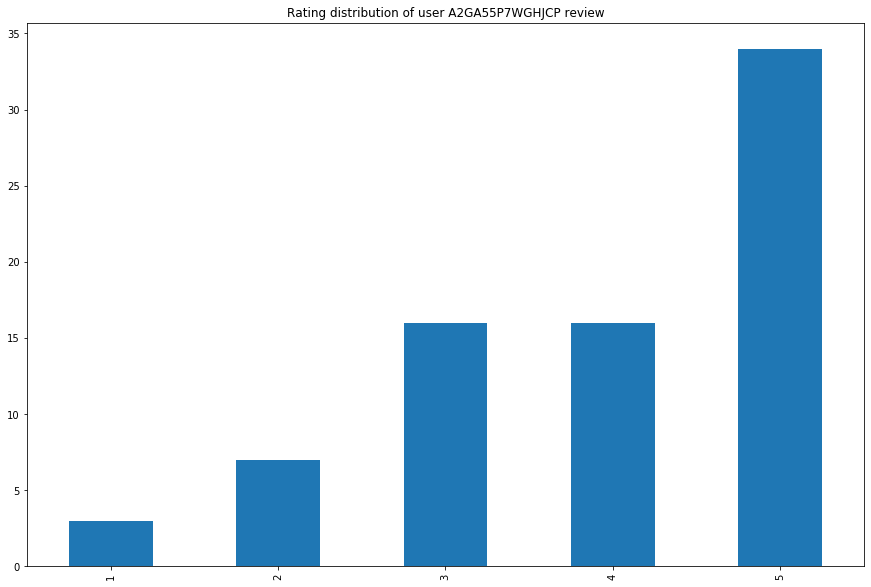

In [44]:
def plot_user(reviewerID):
    df_1user = df[df['reviewerID'] == reviewerID]['overall']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Rating distribution of user {} review'.format(df[df['reviewerID'] == reviewerID]['reviewerID'].iloc[0]))
    plt.show()

plot_user('A2GA55P7WGHJCP')

It can be observed that the user is liked of most of the products

Most popular words used by the user for different ratings are observed. (2-grams and 3-grams are chosen for analysis)

In [55]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df3 = df[(df['reviewerID'] == userid) & (df['overall'] == score)]['reviewText']
    else:
        df3 = df[df['overall'] == score]['reviewText']
        
    count = len(df3)
    total_text = ' '.join(df3)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2GA55P7WGHJCP')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    #test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
     Count Occur %                      Phrase
0      1.0  33.33%         (list, prominently)
1      1.0  33.33%             (slot, abdomen)
2      1.0  33.33%                (month, old)
3      1.0  33.33%     (legs, purchase, large)
4      1.0  33.33%              (skin, slough)
..     ...     ...                         ...
136    1.0  33.33%             (itch, redness)
137    1.0  33.33%       (prominently, amazon)
138    1.0  33.33%  (amazon, incur, liability)
139    1.0  33.33%               (large, look)
140    1.0  33.33%     (death, please, amazon)

[141 rows x 3 columns]
score 2 reviews most popular 2-gram / 3-gram:
   Count Occur %          Phrase
0    2.0  28.57%  (need, return)
1    2.0  28.57%    (true, size)
score 3 reviews most popular 2-gram / 3-gram:
Empty DataFrame
Columns: []
Index: []
score 4 reviews most popular 2-gram / 3-gram:
   Count Occur %            Phrase
0    4.0   25.0%  (wear, camisole)
score 5 reviews most 

Now, the popular words for all users are observed

In [56]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
   Count Occur %          Phrase
0  932.0   8.33%    (look, like)
1  580.0   5.18%  (waste, money)
2  558.0   4.99%    (send, back)
3  523.0   4.67%     (n't, even)
4  388.0   3.47%    (could, n't)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  1081.0   6.99%    (look, like)
1   734.0   4.75%    (send, back)
2   544.0   3.52%    (would, n't)
3   492.0   3.18%   (order, size)
4   472.0   3.05%  (think, would)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  1596.0   5.25%    (look, like)
1  1003.0    3.3%   (order, size)
2   944.0    3.1%  (think, would)
3   924.0   3.04%    (would, n't)
score 4 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  2644.0   4.53%     (fit, well)
1  2232.0   3.82%    (look, like)
2  2211.0   3.79%  (really, like)
3  1926.0    3.3%    (well, make)
score 5 reviews most popular 2-gram / 3-gram:
    Count Occur %           

Now, only the adjectives are taken into consideration, as those express opinion and nouns don't.

In [57]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df3 = df[(df['reviewerID'] == userid) & (df['overall'] == score)]['reviewText']
    else:
        df3 = df[df['overall'] == score]['reviewText']
        
    count = len(df3)
    total_text = ' '.join(df3)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [61]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2GA55P7WGHJCP')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
    Count Occur %        Phrase
0     2.0  66.67%         large
1     2.0  66.67%          wear
2     1.0  33.33%          skin
3     1.0  33.33%         avoid
4     1.0  33.33%         chart
5     1.0  33.33%        -could
6     1.0  33.33%           big
7     1.0  33.33%     expensive
8     1.0  33.33%         latex
9     1.0  33.33%          tiny
10    1.0  33.33%           old
11    1.0  33.33%         upper
12    1.0  33.33%          much
13    1.0  33.33%  anaphylactic
14    1.0  33.33%         smoky
15    1.0  33.33%        amazon
score 2 reviews most popular adjectives word:
   Count Occur %       Phrase
0    5.0  71.43%         good
1    3.0  42.86%        small
2    2.0  28.57%          big
3    2.0  28.57%        large
4    2.0  28.57%        great
5    2.0  28.57%         much
6    2.0  28.57%         thin
7    2.0  28.57%         long
8    2.0  28.57%         true
9    2.0  28.57%  comfortable
score 3 reviews most popular adjec